## Loading Data

<Figure size 720x504 with 0 Axes>

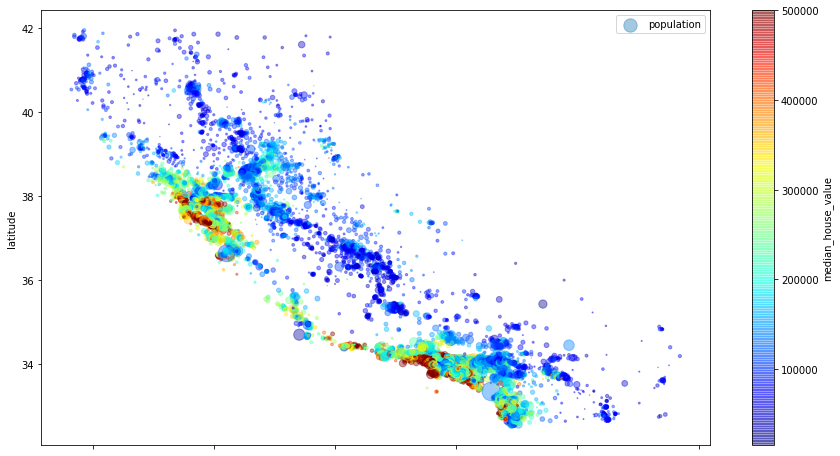

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
df=pd.read_csv("data.csv")
plt.figure(figsize=(10,7))
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
        s=df["population"]/100, label="population", figsize=(15,8),
        c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True,
    )
plt.legend()

## Preprocessing

In [2]:
df.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

In [3]:
median = df['total_bedrooms'].median()
df['total_bedrooms'].fillna(median,inplace=True)
df.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
        ("imputer", SimpleImputer(strategy="median")),
   ])

In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
housing_num = df.drop("ocean_proximity", axis=1)
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])
X= full_pipeline.fit_transform(df)

In [7]:
y=df["median_house_value"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Prediction

In [8]:
from sklearn.tree import DecisionTreeRegressor
dtr_reg = DecisionTreeRegressor(max_depth=20)

In [9]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)

In [33]:
from sklearn.ensemble import AdaBoostRegressor
ada_reg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=10),n_estimators=300)

In [11]:
from sklearn.ensemble import GradientBoostingRegressor
GBR_reg = GradientBoostingRegressor(random_state=0)

In [12]:
import xgboost as xgb
XGB_reg=xgb.XGBRegressor() 

## Validation

In [34]:
from sklearn.model_selection import cross_val_score
for reg in (dtr_reg,forest_reg,ada_reg,GBR_reg,XGB_reg):
    reg.fit(X_train, y_train)
    print(reg.__class__.__name__, cross_val_score(reg, X_train, y_train, cv=2))

DecisionTreeRegressor [0.99999768 0.99998442]
RandomForestRegressor [0.99999874 0.99998295]
AdaBoostRegressor [0.99999895 0.99998628]
GradientBoostingRegressor [0.9999427  0.99993077]
XGBRegressor [0.99998599 0.99997503]


In [35]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
for reg in (dtr_reg,forest_reg,ada_reg,XGB_reg,GBR_reg,):
    housing_predictions = reg.predict(X_test)
    forest_mse = mean_squared_error(y_test, housing_predictions)
    forest_rmse = np.sqrt(forest_mse)
    print(reg.__class__.__name__, " RMSE : ", forest_rmse)

DecisionTreeRegressor  RMSE :  123.06935407766849
RandomForestRegressor  RMSE :  111.81746982924226
AdaBoostRegressor  RMSE :  120.88788188457575
XGBRegressor  RMSE :  292.3729224361794
GradientBoostingRegressor  RMSE :  860.4829788570964


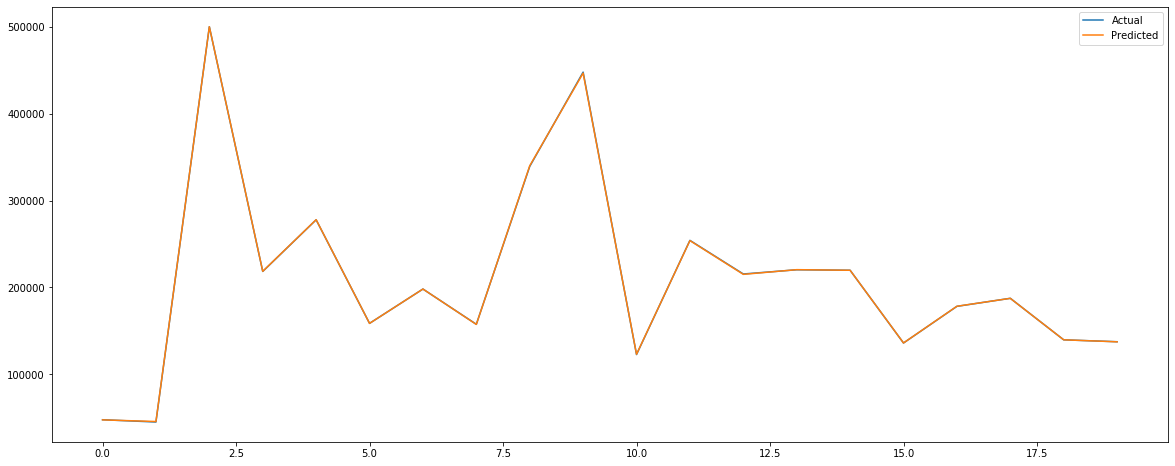

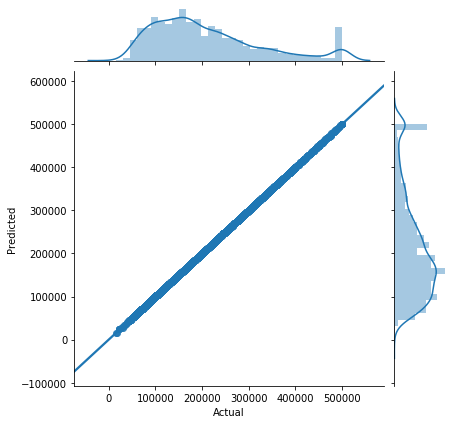

In [56]:
test = pd.DataFrame({'Predicted': XGB_reg.predict(X_test),'Actual':y_test})
fig= plt.figure(figsize=(20,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:20])
plt.legend(['Actual','Predicted'])
sns.jointplot(x='Actual',y='Predicted',data=test,kind='reg',);